In [113]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numbers
import pandas as pd
from tabulate import tabulate
from statsmodels.stats.outliers_influence import summary_table
from typing import Tuple, Dict
import numpy as np

In [114]:
df = pd.read_csv("data/Usuariosyconsumodeelectricidadpormunicipio_clean.csv", dtype={
    'Cve_Edo': 'string',
    'Cve_Inegi': 'string',
    'Cve_Mun': 'string',
    'Estado': 'string',
    'Municipio': 'string',
    'Tarifa': 'string',
    'Periodo': 'string',
    'Usuarios': 'int64',
    'Consumo': 'float64',
    'ISO': 'string'
})

In [115]:
def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt="orgtbl"))

In [116]:
def transform_variable(df: pd.DataFrame, x:str)->pd.Series:
    if isinstance(df[x][0], numbers.Number):
        return df[x] # type: pd.Series
    else:
        return pd.Series([i for i in range(0, len(df[x]))])

In [117]:
def linear_regression(df: pd.DataFrame, x:str, y: str)->Dict[str, float]:
    fixed_x = transform_variable(df, x)
    model= sm.OLS(df[y],sm.add_constant(fixed_x)).fit()
    bands = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
    #print(bands['[0.025'])
    #print(bands['0.975]'])
    print_tabulate(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0])
    coef = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef']
    r_2_t = pd.read_html(model.summary().tables[0].as_html(),header=None,index_col=None)[0]
    return {'m': coef.values[1], 'b': coef.values[0], 'r2': r_2_t.values[0][3], 'r2_adj': r_2_t.values[1][3], 'low_band': bands['[0.025'][0], 'hi_band': bands['0.975]'][0]}

In [118]:
def plt_lr(df: pd.DataFrame, x:str, y: str, m: float, b: float, r2: float, r2_adj: float, low_band: float, hi_band: float, colors: Tuple[str,str]):
    fixed_x = transform_variable(df, x)
    df.plot(x=x,y=y, kind='scatter')
    #print(df[[x,y]])
    plt.plot(df[x],[ m * x + b for _, x in fixed_x.items()], color=colors[0])
    #print([ m * x + b for _, x in fixed_x.items()])
    #print(fixed_x.items())
    plt.fill_between(df[x],
                     [ m * x  + low_band for _, x in fixed_x.items()],
                     [ m * x + hi_band for _, x in fixed_x.items()], alpha=0.2, color=colors[1])

C:\Users\saulp\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\saulp\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\saulp\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


|       |      coef |   std err |      t |   P>|t| |   [0.025 |   0.975] |
|-------+-----------+-----------+--------+---------+----------+----------|
| const | 1.94e+11  |  2.84e+09 | 68.268 |   0     | 1.87e+11 | 2.01e+11 |
| 0     | 3.635e+09 |  6.79e+08 |  5.352 |   0.002 | 1.97e+09 | 5.3e+09  |


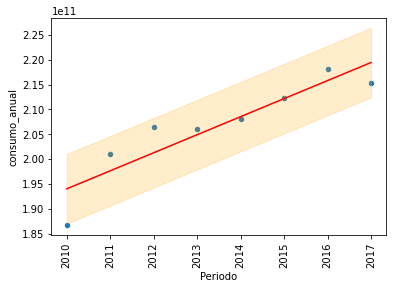

In [119]:
#df = pd.read_csv("csv/typed_uanl.csv") # type: pd.DataFrame
#print_tabulate(df.head(50))
df_by_con = df.loc[(df["Estado"] == "Nacional") & (df["Municipio"] != "Total Estatal") & (df["Tarifa"] == "TOTAL")]\
                .groupby("Periodo").aggregate(consumo_anual=pd.NamedAgg(column="Consumo", aggfunc=pd.DataFrame.mean))
#df_by_con["consumo_anual"] = df_by_con["consumo_anual"] / df_by_con["consumo_anual"].max()
df_by_con.reset_index(inplace=True)
#normalized_df=(df_by_con-df_by_con.mean())/df_by_con.std()
# df_by_sal["sueldo_mensual"] = df_by_sal["sueldo_mensual"]**10
#print_tabulate(df_by_sal.head(5))
a = linear_regression(df_by_con, "Periodo", "consumo_anual")
#print(a)
plt_lr(df=df_by_con, x="Periodo", y="consumo_anual", colors=('red', 'orange'), **a)

plt.xticks(rotation=90)
plt.savefig('images/lr_consumo_anual.png')
plt.show()
plt.close()